# ECON622: Computational Economics with Data Science Applications

Transformers and Attention

Jesse Perla (University of British Columbia)

# Overview

## Summary

-   Describe “attention” with function approximation and relate to
    kernels and similarity
-   Describe transformers, the architecture that which makes LLMs
    possible
-   Give intuition on how/when transformers can work
-   Describe it more generally as a tool for sequential and set-based
    data (e.g., graphs, images)

## References

-   The transformer model is complicated and uses some building blocks
    we haven’t formally introduced
-   These notes are a bare-bones introduction.
-   Mellisa Dell’s [Course](https://econdl.github.io/) has plenty of
    details:
    -   [Sequential
        Data](https://econdl.github.io/intro/2023/01/20/lecture3.html),
        [Transformers](https://econdl.github.io/intro/2023/01/21/lecture4.html)
        and [More
        Transformers](https://econdl.github.io/intro/2023/01/22/lecture5.html)
-   [ProbML Book 1](https://probml.github.io/pml-book/book1.html) and
    [ProbML Book 2](https://probml.github.io/pml-book/book2.html)

# Attention

## Reminder: Kernel Regression

-   Recall in the Kernels/GP lecture we discussed how we can define a
    kernel to do pairwise comparisons of two inputs form a set of data
    $X = \{x_1, x_2, \ldots, x_n\}$ with outputs
    $Y = \{y_1, y_2, \ldots, y_n\}$.
    -   $\mathcal{K}(x_i, x_j)$ is a measure of similarity between $x_i$
        and $x_j$.
    -   Then, for a new $x$, we could define a vector of similarity
        scores, $\alpha \equiv [\mathcal{K}(x, x_i)]_{i=1}^N$
    -   And “predict” a $y(x)$ as a weighted sum of the $y_i$’s $$
        y(x) \approx \sum_{i=1}^n \mathcal{K}(x, x_i) y_i = \alpha \cdot Y
        $$
-   Non-parametric, with potentially infinite-dimensional feature spaces

## Look-up Tables

-   We can think of a Kernel regression as a non-parametric model of
    attention (see ProbML Book 1 15.4.2)
-   A crude way to think of this is as a fuzzy look-up table
    1.  Take a **query**, $x$, and look **keys**, $x_i$, which are
        similar. Score by $\alpha_i$
        -   The score of similarity is a dot-product of the query $x$
            and the key $x_i$
        -   Normalize to probability,so $\sum \alpha_i = 1$
    2.  Then with a **value** $y_i$ associated with each key, we can get
        an average value of the $y_i$’s weighted by the $\alpha_i$’s

## Parametric Version

-   Taking that inspiration, we want to define a version of this which
    is parametric (i.e., it will not require saving all the data in
    memory) and is differentiable
    -   To be parametric, replace the fixed kernels based on the data
        with a parametric form as a learned embedding
    -   In order to be differentiable, we want to replace a fixed lookup
        table with a probabilistic one
-   Kernel Regressions evaluated on new $\{x_1, \ldots x_n\}$ required
    pairwise comparison within that set, and across all previous data.
    -   Parametric versions can just compare the new $x$ to each other
        pairwise using the embedding
-   See [ProbML Book 1 Section
    15.4](probml.github.io/pml-book/book1.html) and [ProbML Book 2
    Section 16.2.7](probml.github.io/pml-book/book2.html) for more

## Mapping to an Embedding Space

-   First, lets separate out **query** and **key** to be more general
-   Map the inputs, $x\in\mathbb{R}^h$, with a linear embedding into $d$
    dimensional space
    -   $q = W_Q x$ for $W_Q \in \mathbb{R}^{d \times h}$
-   Map each of $m$ keys into a similar $d$ dimensional space (keys and
    queries can be different)
    -   $k = W_K x$ for $W_K \in \mathbb{R}^{d \times h}$
    -   Depending on circumstances, possibly $y = W_Y x$ for
        $W_Y \in \mathbb{R}^{v \times h}$
-   Associate a $v$ dimensional **value** with each key
-   Stack up the $K \in \mathbb{R}^{m \times d}$ and
    $V \in \mathbb{R}^{m \times v}$

## Attention for a Single “Query”

-   Given a $q$, the attention is $$
    \begin{aligned}
    \text{Attn}(q, K, V) &\equiv \sum_{i=1}^m \alpha_i(q, K)\cdot V_i\\
      \alpha_i(q, K) &\equiv \frac{\exp(a(q, K_i))}{\sum_{j=1}^m \exp(a(q, K_j))}\\
      a(q, k) &\equiv q \cdot k/\sqrt{d}
    \end{aligned}
    $$
-   Returns the **value** weighted by probabilities (i.e., a softmax of
    the similarity between the **query** and each **key**)
-   Dot-product similarity, rescaling by $\sqrt{d}$ is to normalize

## Interpretation

A standard, broad interpretation attention for tokens

-   The **query** contains what information a token is looking for
-   The **key** contains what type of information a token provides
-   The **value** contains what information is returned

## Attention Layer

-   Typically we are calculating the attention for $n$ batches of the
    embedded inputs
-   Use $W_Q$ to embed inputs, $Q \in \mathbb{R}^{n \times d}$, then $$
    Z = \text{Attn}(Q, K, V) = \text{softmax}\left(\frac{Q K^{\top}}{\sqrt{d}}\right)V \in \mathbb{R}^{n \times v}
    $$
    -   The parameters to “learn” are just the embeddings, $W_Q, W_K$
        and potentially $W_V$

## Self-Attention

-   If the $Q, K,$ and $V$ come from the same data, then it is called
    **self-attention**
    -   Canonical example might be that $X$ are an embedded tokens of a
        sentence
-   That is, if we have a $X\in\mathbb{R}^{h\times n}$ which are basic
    embeddings of the tokens and set $Q = W_Q X, K = W_K X, V = W_V X$,
    $$
    Z = \text{Attn}(W_Q X, W_K X, W_V X) \in \mathbb{R}^{n \times v}
    $$
    -   Note that this makes pairwise comparisons for all $n$

## Multi-Head Attention

-   There will be different senses of similarity for the **query**,
    **key**, and **value**.

-   A powerful approach is to to have multiple self-attention layers
    $j=1,\ldots J$ $$
    Z^j = \text{Attn}(W_Q^j X, W_K^j X, W_V^j X)
    $$

-   Then concatenate the $Z^j$’s and potentially project with embedding
    $W_O$

    $$
    {\small
    \text{MultiHead}(X) = W_O\cdot \begin{bmatrix}\text{Attn}(W_Q^1 X, W_K^1 X, W_V^1 X)\\
    \vdots\\\text{Attn}(W_Q^J X, W_K^J X, W_V^J X)\end{bmatrix}
    }
    $$

    -   “Trainable” parameters are the $W_Q^j, W_K^j, W_V^j, W_O$

## Invariant to Ordering? Add Position

-   In this simple example, the tokens are all treated as pointwise
    comparisons without any sense of “ordering”
    -   i.e., invariant to permutations of $X$. For some tasks, that is
        appropriate
    -   For others, the order of the tokens in a “sentence” is crucial.
-   Solution: embedding tokens, $X$, combined with its position
    -   While one could think of jointly embedding the token with an
        integer index, that is not differentiable
    -   Instead, tricks such as mapping the position to a vector through
        sinusoidal functions. See [Attention is All You
        Need](https://arxiv.org/abs/1706.03762)
-   The word embedding and the position embedding are combined before
    the first Multi-Head Attention layer

## Attention Visualization of $\alpha$

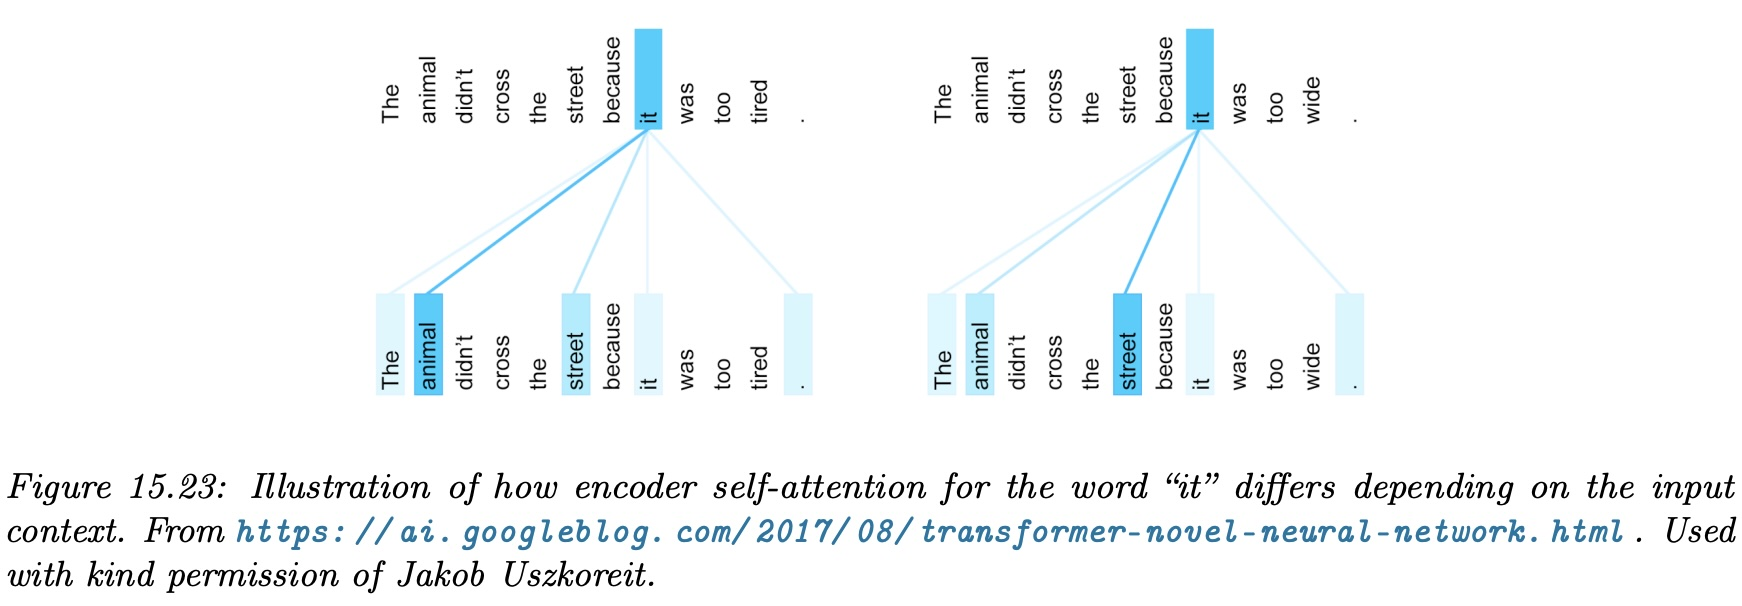

-   Attention lets one point of the input be strongly influenced by
    others in a context-dependent way
-   See the above, which associates the word “it” with “animal” when the
    pronoun needs to be interpreted in context

## Token Prediction

-   Recall with the ChatGPT style prediction of the next token, we need
    to find a $\mathbb{P}(x_t | x_{t-1}, x_{t-2}, \ldots, x_1)$
    -   Where the $t$ might be $128k$ or more, and there might be $50K$
        possible discrete $x_t$ states
-   Attention is central because it can find representations of the
    $x_{t-1}, x_{t-2}, \ldots, x_1$ for conditioning
    -   Self-attention makes it possible for the representations to
        capture the features of the joint distribution of previous
        tokens

# Transformers

## A Marvel of Modern Engineering

-   The **transformer** architecture is a highly efficient, numerically
    stable, parallelizable, and regularized way to use attention
-   Transformers are built using:
    -   One or more **Multi-head self-attention** layers
    -   Flexible NN approximations (**feed forward** in diagram) to map
        the MHA output to a nonlinear functions
    -   Positional encoding tricks to encode ordering of data
    -   Softmax (i.e., logit) to map high-dimensional latent spaces to
        probabilities
    -   Various tricks (LayerNorm, Dropout) , etc. to make the model
        more numerically stable and regularized
    -   “Masking” and other ways to enable self-supervised learning and
        various tasks, and ensure training is done token-by-token

## Example Encoder-Decoder Transformer Architecture

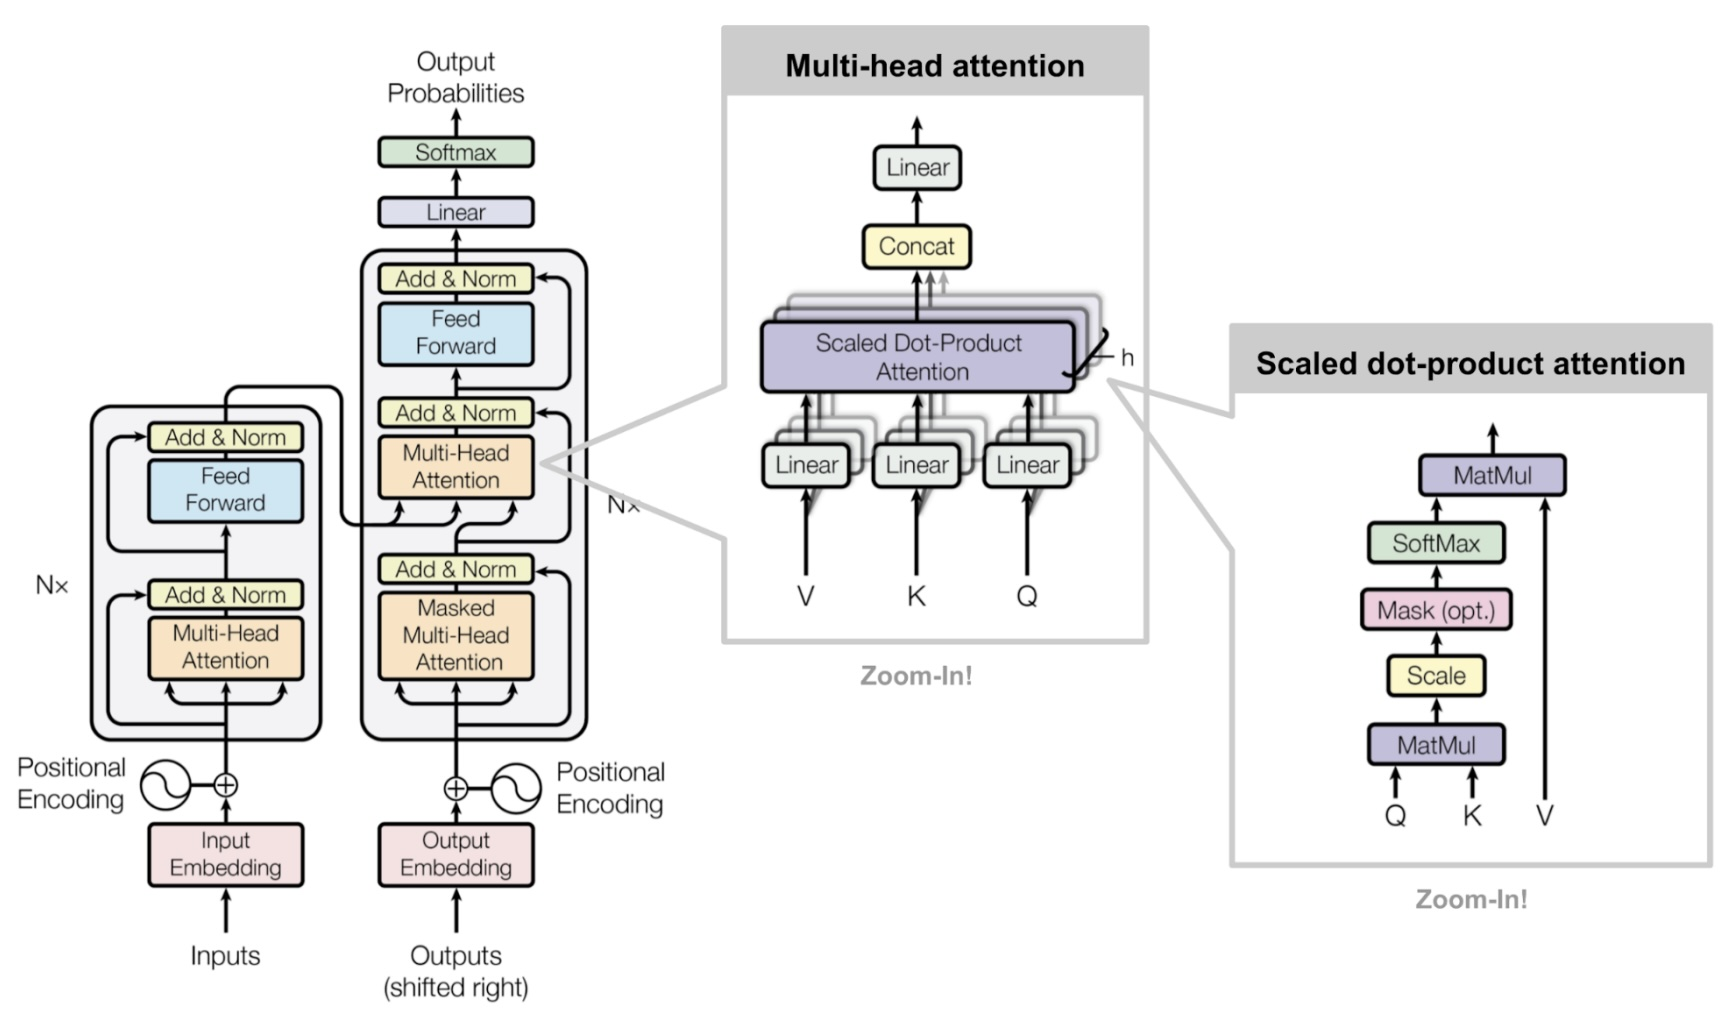

## Sequence to Sequence

-   Early transformer designed for translation tasks (sequence of tokens
    as input to sequence of tokens as output)
    -   i.e., the $\mathbb{P}(y_1, \ldots y_T|x_1, \ldots x_T)$ where
        $T$ might be enormous, and $x,y$ might allow tens of thousands
        of tokens
-   The design of these typically uses a transformer to encode
    $x_1,\ldots x_T$ into a representation, then another to decode, and
    take the representation back to the $y_1, \ldots y_T$ tokens

## Decoder-Only Transformer

-   To generate text token by token, as in the Sequential Generation can
    use a single transformer
    -   i.e., the $\mathbb{P}(x_{T+1}|x_1, \ldots x_T)$
-   This embeds the previous tokens, $x_1, \ldots x_T$ to generate a PMF
    over the next one.
-   Decoder-only because a single transformer is used the end-result is
    the token output probabilities

## Encoder-Only Transformer

-   For tasks like classification, the transformer can be be used to
    simply encode an internal representation of the input for a
    downstream task like classification
    -   i.e., the
        $\mathbb{P}(\text{Class}(x_1, \ldots x_T) = C_i |x_1, \ldots x_T)$
-   Then the final layer can be used to classify the input using
    standard techniques
-   This is called an Encoder-Only transformer because the end-result is
    the internal representation

## Not Just for Text

-   The basic idea of attention is useful whenever there are parts of
    the data where the representations work best if parts of the data
    are compared to other parts
-   For example, can use transformers with images
    -   For those, the “position” might be patches of the image
-   Another example are working with graphs/networks
    -   For that, the “position” might help you to find distances
        between nodes in the graph